# Base de datos de prueba para los algoritmos de las K-medias y la mezcla de Gaussianas.

In [30]:
import random
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.datasets import make_blobs

In [31]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0, cluster_std=0.40)
data = pd.DataFrame(data=X, columns=['feature1', 'feature2'])
data.head()

,feature1,feature2
0,-1.239037,2.818515
1,1.356305,4.243244
2,-1.516209,2.991262
3,-1.359763,2.901875
4,-1.928633,2.518606


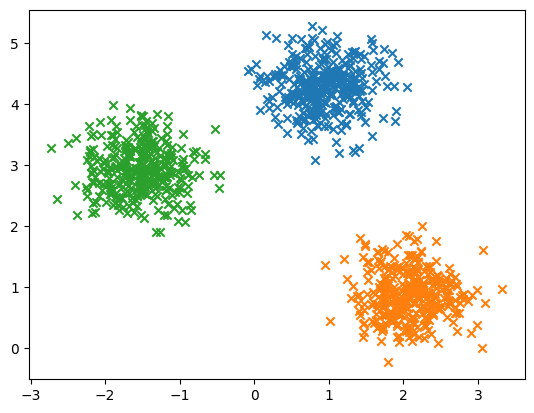

In [32]:
for i in range(3):
  data = X[y==i,:]
  plt.scatter(data[:, 0], data[:, 1], marker="x")

### Medimos la distancia entre cada punto y el centroide  (Distancia Euclidiana)

In [33]:
def distanciaEuclidiana(x1,x2):
    return np.sqrt( np.sum( (x1-x2)**2 ))

In [34]:
class KMeans():

    def __init__(self, K=3, max_iters = 100, plot_steps = False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # Matriz de indices de muestra para cada cluster/grupo
        # Para cada clase inicializamos una lista vacia
        self.clusters = [ [] for i in range(self.K) ]

        # Vector de caracteristicas medio para cada cluster/grupo
        self.centroides = []


    # Dado que es un aprendizaje No Supervisado, no tenemos ninguna etiqueta/label
    # debemos implementar un metodo predict
    def predict(self, X):
        self.X = X
        self.numSamples, self.numFeatures = X.shape

        # Iniciliazamos los Centroides de forma aleatoria
        indecesRandomSamples = np.random.choice(self.numSamples, self.K, replace=False) #Replace = False para evitar tomar el mismo indice dos veces
        self.centroides = [self.X[i] for i in indecesRandomSamples]

        # Optimizacion
        for i in range(self.max_iters):

            # Actualizamos los clusters/grupos
            self.clusters = self.crearClusters(self.centroides)
            if self.plot_steps:
                self.graficar()

            # Actualizamos Centroides
            centroidesAnteriores = self.centroides
            self.centroides = self.obtenerCentroides(self.clusters)

            # Chequeamos si convergen
            if self.converge(centroidesAnteriores, self.centroides):
                break

        # Retornamos los Labels de los centroides
        return self.obtenerLabels(self.clusters)
    
    def obtenerLabels(self, clusters):
        labels = np.empty(self.numSamples)
        for indexCluster, cluster in enumerate(clusters):
            for indexSample in cluster:
                labels[indexSample] = indexCluster
        return labels

    def crearClusters(self, centroides):
        clusters = [[] for i in range(self.K)]
        for i, sample in enumerate(self.X):
            # Obtenemos el centroide mas cercano
            indexCentroide = self.centroideMasCercano(sample, centroides)
            clusters[indexCentroide].append(i)
        
        return clusters
    
    def centroideMasCercano(self, sample, centroides):
        distancias = [distanciaEuclidiana(sample, punto) for punto in centroides]
        indexMasCercano = np.argmin(distancias)
        return indexMasCercano
    
    def obtenerCentroides(self, clusters):
        centroides = np.zeros( (self.K, self.numFeatures) )
        for i, cluster in enumerate(clusters):
            clusterMean = np.mean( self.X[cluster], axis = 0)
            centroides[i] = clusterMean
        return centroides
    
    def converge(self, centroidesAnteriores, centroides):
        distancias = [ distanciaEuclidiana(centroidesAnteriores[i], centroides[i]) for i in range(self.K) ]
        return sum(distancias) == 0 # si es cero, significa que no hay mas cambios en los centroides, por ende converge
    
    def graficar(self):
        fig, ax = plt.subplots(figsize = (12,8))
        for i, index in enumerate(self.clusters):
            punto = self.X[index].T
            ax.scatter(*punto)
        for punto in self.centroides:
            ax.scatter(*punto, marker="x", color="black", linewidth=2)
        
        plt.show()


In [35]:
print(X.shape)
clusters = len(np.unique(y))
print(clusters)

(1000, 2)
3


### Graficamos paso por paso la variacion de los centroides, se van actualizando los Labels/Grupos con cada iteracion

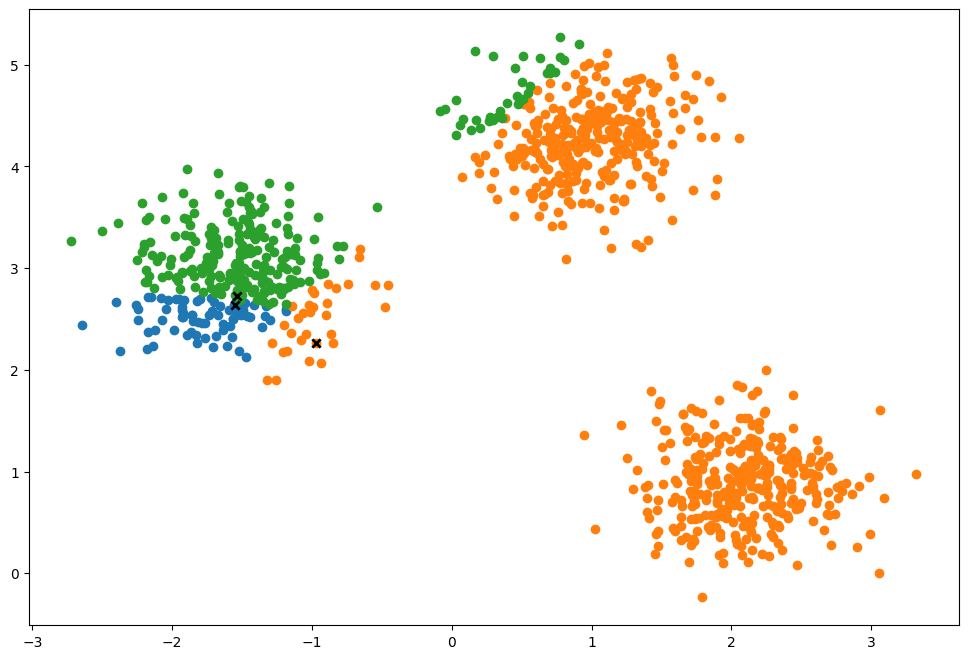

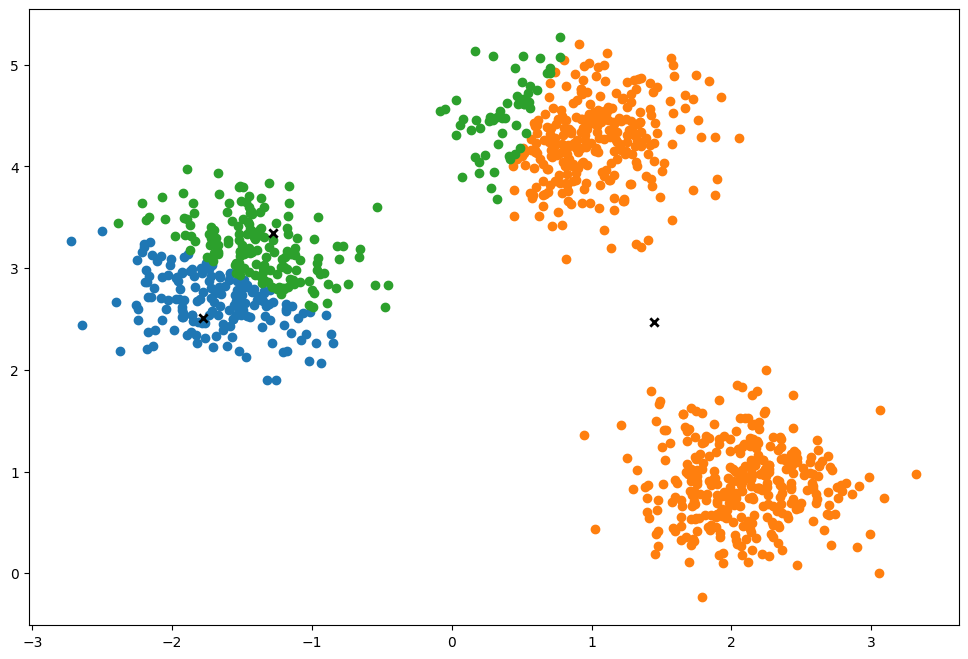

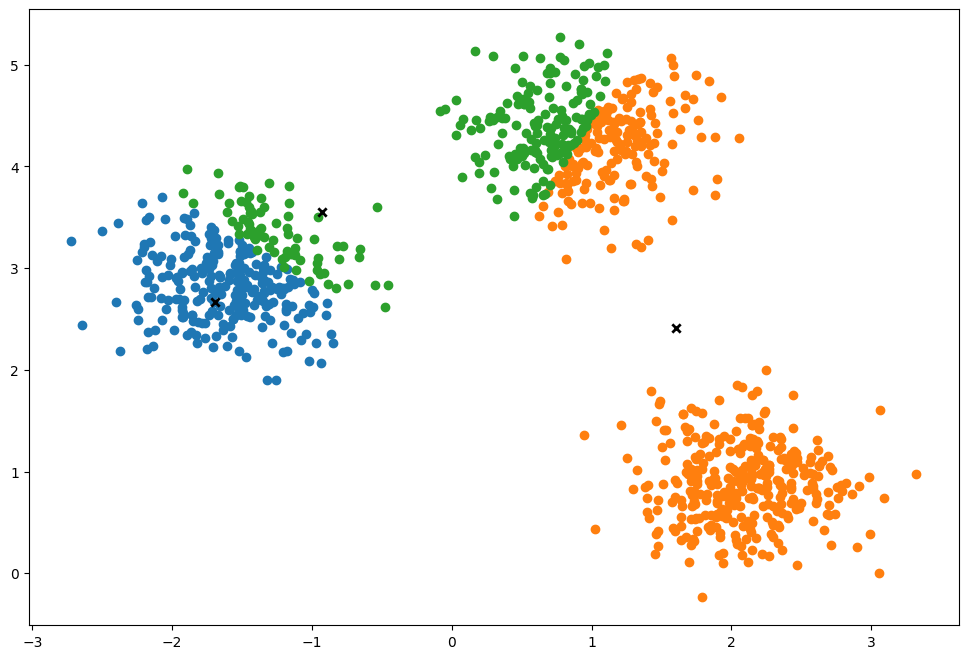

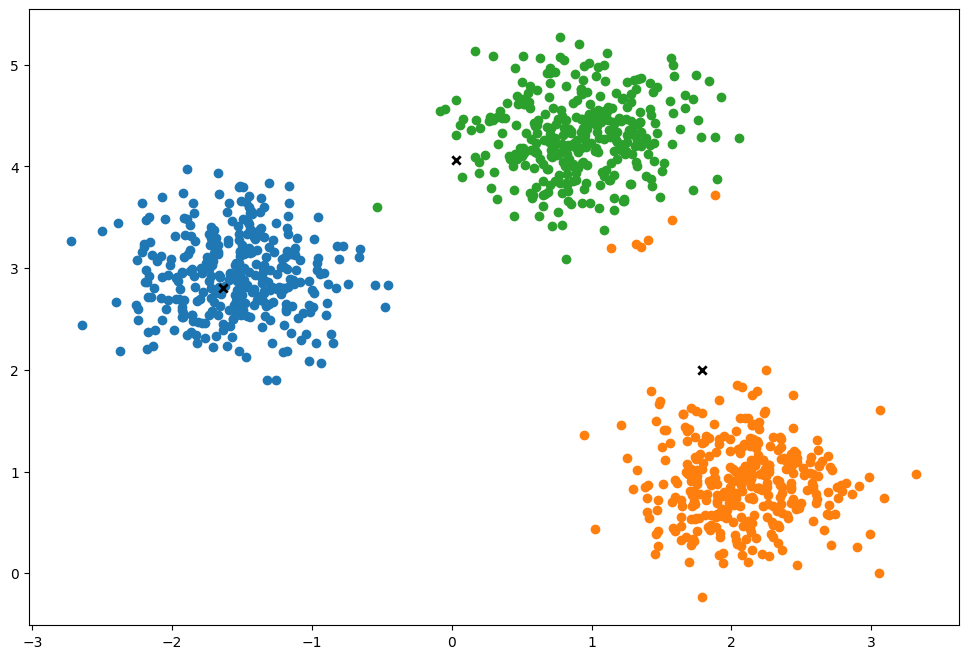

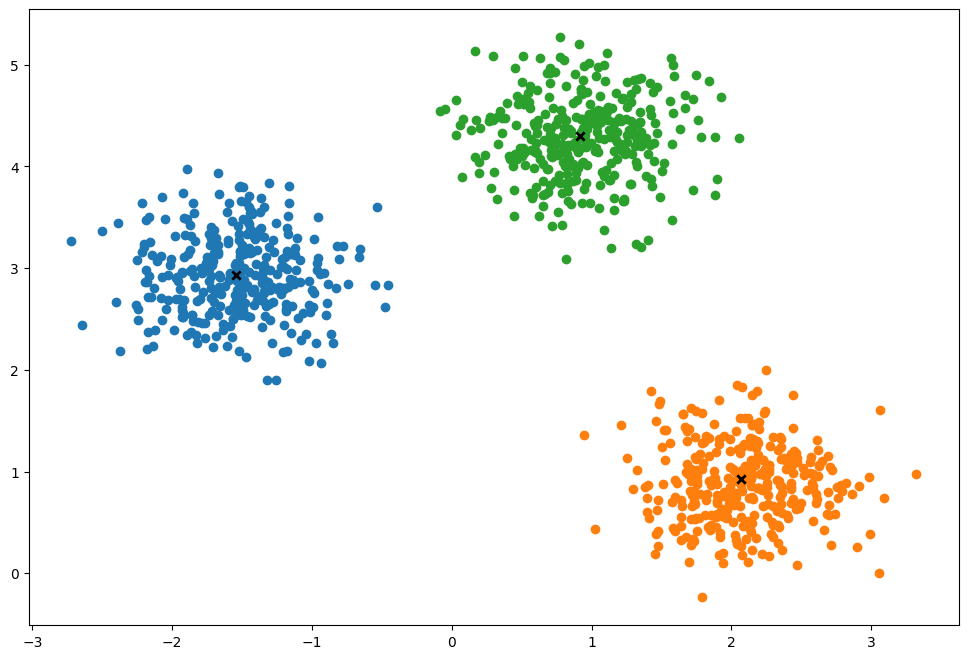

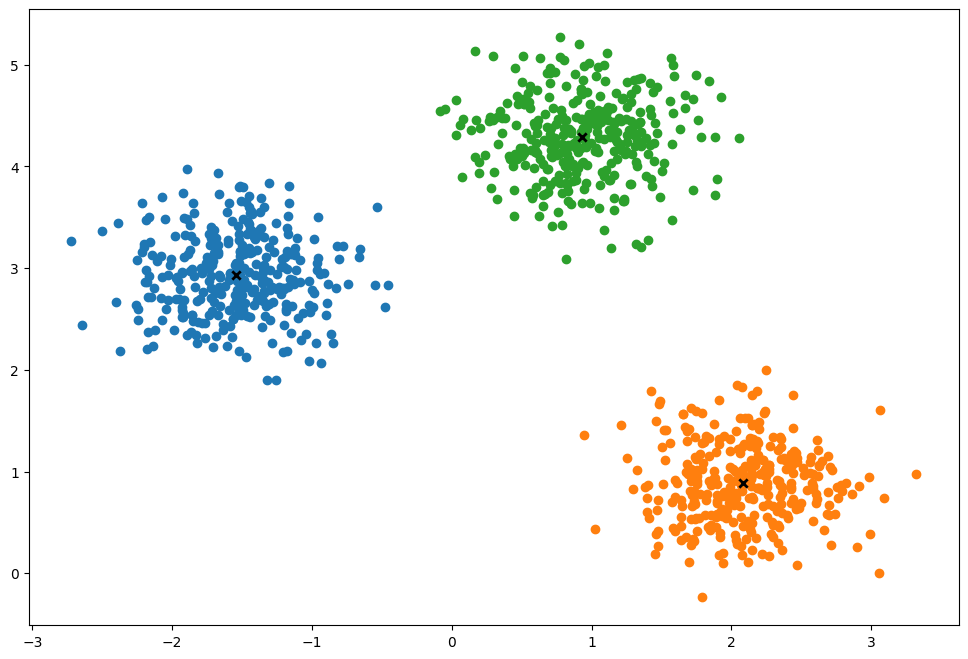

In [36]:
k = KMeans(K=clusters, max_iters=150, plot_steps=True)
y_pred = k.predict(X)

### Grafica Resultante con los Puntos Finales de los Centroides 

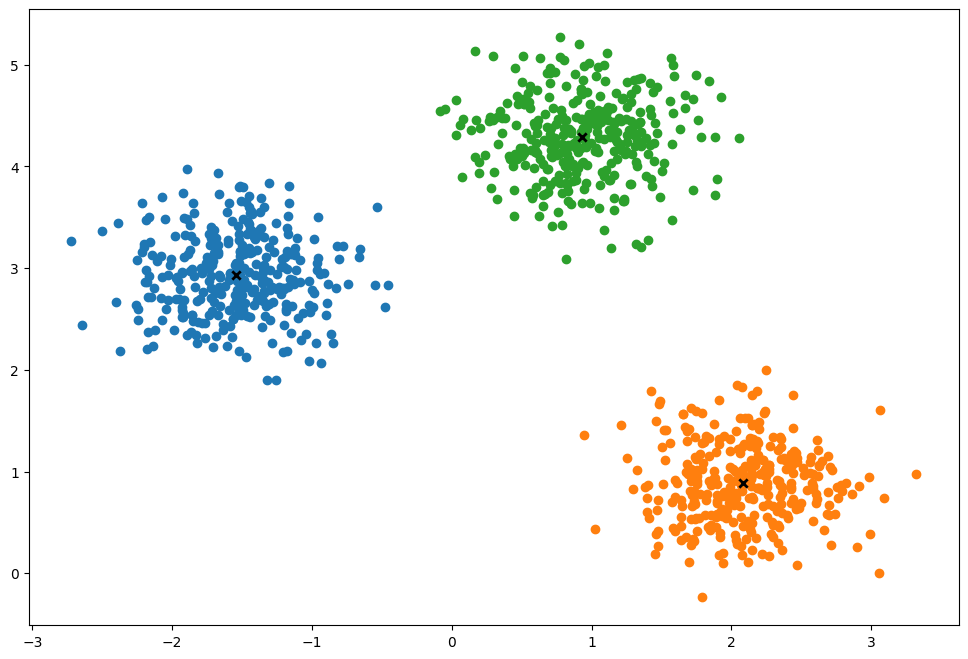

In [37]:
k.graficar()

### IMPLEMENTACIÓN MEZCLA DE GAUSSIANA

In [42]:
class MezclaGaussiana:
    '''
        This class is the implementation of the Gaussian Mixture Models 
        inspired by sci-kit learn implementation.
    '''
    def __init__(self, K, max_iter = 100, comp_names=None):
        '''
            This functions initializes the model by seting the following paramenters:
                :param K: int
                    The number of clusters in which the algorithm must split
                    the data set
                :param max_iter: int, default = 100
                    The number of iteration that the algorithm will go throw to find the clusters
                :param comp_names: list of strings, default=None
                    In case it is setted as a list of string it will use to
                    name the clusters
        '''
        self.K = K
        self.max_iter = max_iter
        if comp_names == None:
            self.comp_names = [f"comp{index}" for index in range(self.K)]
        else:
            self.comp_names = comp_names
        # pi list contains the fraction of the dataset for every cluster
        self.pi = [1/self.K for comp in range(self.K)]

    def multivariate_normal(self, X, mean_vector, covariance_matrix):
        '''
            This function implements the multivariat normal derivation formula,
            the normal distribution for vectors it requires the following parameters
                :param X: 1-d numpy array
                    The row-vector for which we want to calculate the distribution
                :param mean_vector: 1-d numpy array
                    The row-vector that contains the means for each column
                :param covariance_matrix: 2-d numpy array (matrix)
                    The 2-d matrix that contain the covariances for the features
        '''
        return (2*np.pi)**(-len(X)/2)*np.linalg.det(covariance_matrix)**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector))/2)

    def fit(self, X):
        '''
            The function for training the model
                :param X: 2-d numpy array
                    The data must be passed to the algorithm as 2-d array, 
                    where columns are the features and the rows are the samples
        '''
        # Spliting the data in n_componets sub-sets
        new_X = np.array_split(X, self.K)
        # Initial computation of the mean-vector and covarience matrix
        self.mean_vector = [np.mean(x, axis=0) for x in new_X]
        self.covariance_matrixes = [np.cov(x.T) for x in new_X]
        # Deleting the new_X matrix because we will not need it anymore
        del new_X
        for iteration in range(self.max_iter):
            ''' --------------------------   E - STEP   -------------------------- '''
            # Initiating the r matrix, evrey row contains the probabilities
            # for every cluster for this row
            self.r = np.zeros((len(X), self.K))
            # Calculating the r matrix
            for n in range(len(X)):
                for k in range(self.K):
                    self.r[n][k] = self.pi[k] * self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                    self.r[n][k] /= sum([self.pi[j]*self.multivariate_normal(X[n], self.mean_vector[j], self.covariance_matrixes[j]) for j in range(self.K)])

            ''' --------------------------   M - STEP   -------------------------- '''
            # Updating the pi list
            self.pi = [np.mean(self.r[:,k]) for k in range(self.K)]
            # Updating the mean-vector and covariance matrix for every cluster
            for k in range(self.K):
                # Updating the mean vector
                self.mean_vector[k] = sum([self.r[n][k]*X[n] for n in range(len(X))])/sum([self.r[n][k] for n in range(len(X))])
                # Updating the covariance matrix
                temp = np.zeros((X.shape[1], X.shape[1]))
                for n in range(len(X)):
                    temp += self.r[n][k]*np.outer((X[n]-self.mean_vector[k]), (X[n]-self.mean_vector[k]).T)
                self.covariance_matrixes[k] = temp/sum([self.r[n][k] for n in range(len(X))])
    


def graficarGauss(X, model):
    # Getting the x and y axis limits
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    # Creating the meshgrid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    # Flattening the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    # Calculating the predictions
    Z = np.argmax(model.predict_proba(grid), axis=1)
    Z = Z.reshape(xx.shape)
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=model.predict(X), cmap=plt.cm.Spectral)
    plt.title("Gaussian Mixture Model")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()
    

In [43]:
GaussianMix = MezclaGaussiana(K=clusters)
GaussianMix.fit(X)

graficarGauss(X, GaussianMix)

AttributeError: 'MezclaGaussiana' object has no attribute 'predict_proba'